# Extreme Event Prediction Using Latent Space

The project that this project tackles is extreme event prediction using the latent space of an autoencoder. This prediction is done by converting the latent space and flow variables (namely kinetic energy and the dissipation rate) to a graph structue and maximizing the modularity of the graph. The code implemented for the modularity maximization is retrieved from Urszula Golyska (2022).

 This notebook will provide an overview of the algorithms that are used to generate the results for the modularity maximization algorithm.

## Changing the Path

Since the project derives dependencies from the previous groups' results, we have decided to put them in a specific folder. This confused Python as it was unable to access material from the old group's folder, therefore we utilize path changes throughout to access the material. Below is an example of how we change the path to allow for retrieveing the autoencoder structure.

In [1]:
import sys
import os


dir_main = os.path.join(os.getcwd())
path_rel = ('..')
path_new = os.path.join(dir_main , path_rel)
print(path_new)

sys.path.append(path_new)


c:\Users\alial\OneDrive\Desktop\AE\year3\Minor\CapstoneProject\TI3165TU-Capstone-Applied-AI-LOCAL\main\..


## Retrieving the Autoencoder

The autoenconder trained by the previous group has been trained on flow. The flow properties this notebook analyzes are are:
- re = 40.0 (Reynolds number)
- nx = 48 (x and y dimensions of a frame)
- nu = 2 (dimension of the velocity vector)
- normalized over the [min, max] range

We were going to use our predecessor's autoencoder at first, but then we have realized that their data was not appropriate for our project as the data did not have enough flow simulation grid points to accurately encode kinetic energy. Therefore, we had to train our own Variational Autoencoder, and generate our own data with higher precision. More details will be given down below.

### Import Statements

In [2]:
from FlowCompression.ClassAE import AE

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

seed = np.random.seed(42) #This is redundant

### Loading the Dataset

We have created a <code>helper</code> file in order to store all of the helper functions that allow us to process the data. This processing is either reading the data through <code>h5py</code> files or simple aerodynamic calculations such as kinetic energy or dissipation rate calculations.

In [3]:
from helper import *

The following block retrieves flow properties that are going to be used for the clustering algorithm. The properties are Reynolds Number stored in <code>re</code> and the dissipation energy of the flow stored in <code>dissip</code> parameters. The recorded time of the flow is stored within the <code>T</code> parameter. N is the number of node pairs within the flow. We have used the <code>data_remover</code> file to reduce the dataset to numpy arrays as it was hard to push the data to GitHub due to its size. To access the data, you can contact the responsible people in the project.

In [4]:
re = 40.0
dissip = np.load('Dissip.npy')
T = len(np.load('t.npy'))
N = 4

The following uses the helper function <code>data_reading</code> from the <code>helper</code> file to read the velocity field of the flow.

In [5]:
u = data_reading(nx=48)
print(f'This is the shape of the flowfield: {u.shape} which is shape [time, nx, nx, nu]')

This is the shape of the flowfield: (2400, 48, 48, 2) which is shape [time, nx, nx, nu]


The following demonstrates how to import the autoencoder that is trained but imported to this notebook *pre-trained*. We are using a variational autoencoder that encodes the flow to 30 dimensions. These latent spaces are then used for the clustering algorithm that is explained down below.

In [6]:
dir_main = os.path.join(os.getcwd())
path_rel = ('..', 'VAE')
path_new = os.path.join(dir_main , *path_rel)
print(path_new)

sys.path.append(path_new)

from VAEClass import VAE_Encoder, VAE_Decoder

c:\Users\alial\OneDrive\Desktop\AE\year3\Minor\CapstoneProject\TI3165TU-Capstone-Applied-AI-LOCAL\main\..\VAE


The following code block allows us to access the encoder and the decoder structures independently. These structures are already pre-trained together thus whatever the encoder encodes, the decoder is able to exactly decode.

In [7]:
model_encoder = VAE_Encoder(encoder_file='vae_encoder_ph_v5.0.h5') #This is to ensure we can separately encode
model_decoder = VAE_Decoder(decoder_file='vae_decoder_ph_v5.0.h5') #This is to ensure we can separately decode

The following block transforms the velocity field to latent space representation that was already loaded after training. The latent space was downloaded as a numpy array, and it is loaded down below.

In [8]:
latent = np.load('vae_latent_space_new_24_1.npy') #This function will decode the velocity time series to its corresponding latent space
print(f'This is the shape of the encoded latent space: {latent.shape} which is the shape [time, 32]')

This is the shape of the encoded latent space: (2400, 32) which is the shape [time, 32]


In an aerodynamic sense, the latent space encodes the modes of the flow. This encoding can be visualized to show which modes of the flow are the storngest i.e. which mode affects the shape of the flow the most. The following two blocks retrieves the modes of the flow and plots them over the time span of the time span.

In [9]:
latent_reshaped = latent.reshape(latent.shape[0], latent.shape[1]) #We reshape the whole latent space for further use since (..., 1, 1, ...) dimensions don't do aything

Since the modes overlap in general, we have used statistics to showcase how distributed the modes are by tracking the mean of all of the modes at one given time span and showing the standard deviation per timespan. This also gives us an indication of how well distributed the modes are around the mean.

In [10]:
mean_latent_modes = np.mean(latent_reshaped, axis=1)
std_latent_modes = np.std(latent_reshaped, axis=1, ddof=1)

print(f'This is the shape of the mean_latent_nodes: {mean_latent_modes.shape}')
print(f'This is the shape of the std_latent_modes: {std_latent_modes.shape}')

This is the shape of the mean_latent_nodes: (2400,)
This is the shape of the std_latent_modes: (2400,)


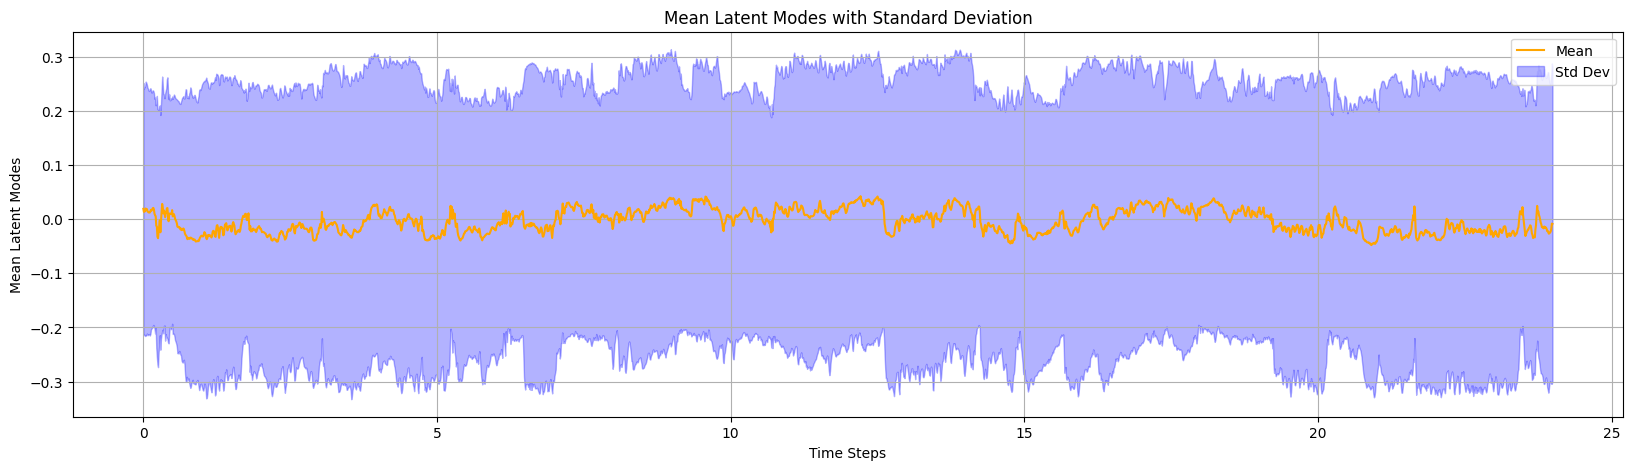

In [11]:
plt.rcParams['figure.figsize'] = [20, 5]  # Adjust the numbers as needed

# Plot mean line
plt.plot(np.arange(mean_latent_modes.shape[0])*0.01, mean_latent_modes, label='Mean', color='orange')

# Fill between mean - std and mean + std
plt.fill_between(np.arange(mean_latent_modes.shape[0])*0.01, (mean_latent_modes - std_latent_modes),
                 (mean_latent_modes + std_latent_modes), color='blue', alpha=0.3, label='Std Dev')

# Customize plot
plt.xlabel('Time Steps')
plt.ylabel('Mean Latent Modes')
plt.title('Mean Latent Modes with Standard Deviation')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## Clustering Algorithm 

The algorithm was developed by Urszula Golyska (2022). What the algorith does is that it translates a given <code> numpy array </code> to a graph and tries to maximize the modularity. This problem is an NP-hard problem, and it is solved through a greedy algorithm which works like the K-means++ algorithm but used in graphs. More information on the algorithm will be given down below. The following sniplet provides calculations that are required for the algorithm.

### Calculating K and D per Picture of Data

The following code utilizes <code> calculate_energy(.) </code> helper function from the <code>helper</code> file. This function uses mathematical formulas to calculate the kinetic energy and the energy dissipation rate of the flow per unit density. These energies are *normalized using the Reynolds Number* given that the flow is aerodynamically dependent on the Reynolds number. A summary of the function is as follows:

<code>calculate_energy(u, re)</code>
- Param: u -> the velocity field in the shape of [time, nx, nx, nu]
- Param: re -> Reynolds number of the flow, this is NOT a hyperparameter and the client requested for it to be 40.0.
- Return: u_k, u_d -> The kinetic energy and the dissipation rate of the flow in [time, nx, nx, nu]

In [12]:
u_k_test, u_d_test = calculate_energy(u)

The method <code>calculate_energy(.)</code> calculates the energy per frame and not throughout the picture. Aerodynamically speaking, this is a wrong implementation of the energy calculation and we would need 1 quantity for the whole picture in general since it is an integral calculation. Therefore, we sum over all [nx, nx] dimensions so as to represent one time span with 1 kinetic and 1 dissipation rate parameter. We also tile the <code>numpy arrays</code> so that they can be concatenated with the latent dimensions afterwards.

In [13]:
u_k_test_actual = np.sum(u_k_test, axis=(1,2)).reshape(u_k_test.shape[0], 1)
u_d_test_actual = np.sum(u_d_test, axis=(1,2)).reshape(u_k_test.shape[0], 1)

# u_k_test_actual_tiled = np.tile(u_k_test_actual, (1, 4))
# u_d_test_actual_tiled = np.tile(u_d_test_actual, (1, 4))

# print(f'This is the shape of u_k actual {u_k_test_actual_tiled.shape}')
# print(f'This is the shape of u_d actual {u_d_test_actual_tiled.shape}')

The following block is a visual check to see whether there is even extreme events in the flow. The idea is that extreme events would have high values of dissipation rate and kinetic energy. This is clearly visible, and that there are plenty of extreme events to be clustered.

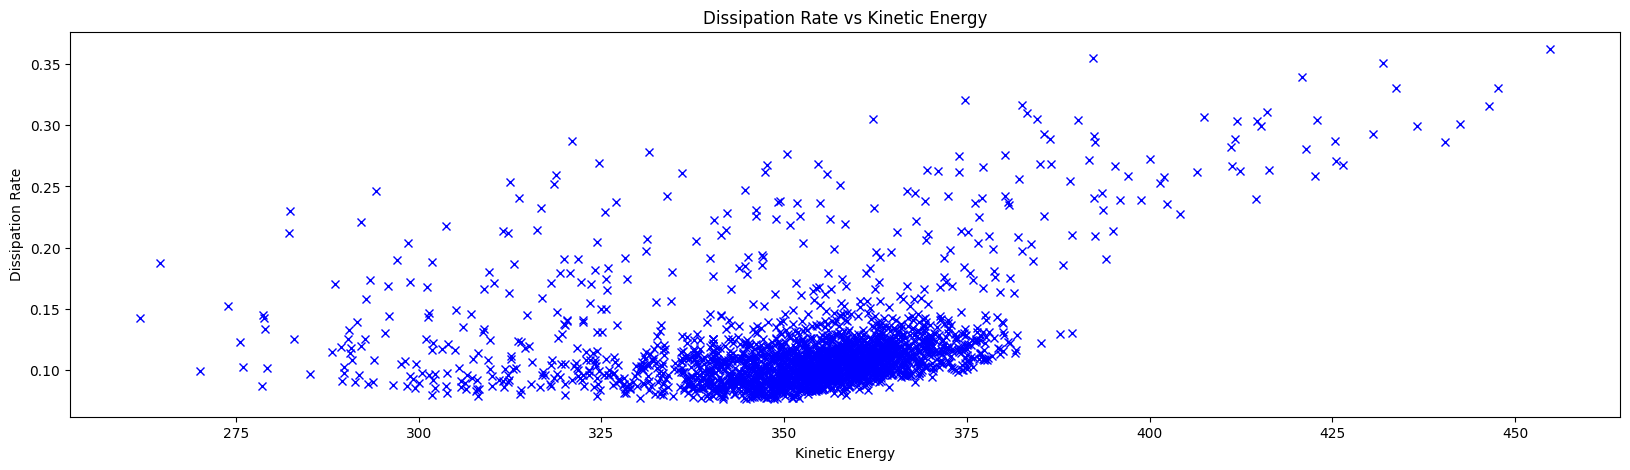

In [14]:
u_k_reshaped = u_k_test_actual.reshape(np.sum(np.sum(u[:, :, :, 0] ** 2 + u[:, :, :, 1] ** 2, axis=1), axis=1).shape[0], 1) * (2 * np.pi) ** 2
u_d_reshaped = u_d_test_actual.reshape(u_d_test_actual.shape[0], 1)
plt.rcParams['figure.figsize'] = [20, 5]  # Adjust the numbers as needed
plt.xlabel('Kinetic Energy')
plt.ylabel('Dissipation Rate')
plt.title('Dissipation Rate vs Kinetic Energy')
plt.plot(u_k_reshaped, dissip, 'x', color='b')

The code below uses statistical methods to understand how varied the kinetic energy and the dissipation energy are. We take the mean and the standard deviation of all of these variables and the results are output for the reader's convenience.

In [15]:
u_k_mean = np.mean(u_k_test_actual.reshape(u_k_test_actual.shape[0]), axis=0)
u_k_std = np.std(u_k_test_actual.reshape(u_k_test_actual.shape[0]), axis=0, ddof=1)

u_d_mean = np.mean(u_d_test_actual.reshape(u_d_test_actual.shape[0]), axis=0)
u_d_std = np.std(u_d_test_actual.reshape(u_d_test_actual.shape[0]), axis=0, ddof=1)

print(f'This is the the mean value of u_k with std {u_k_mean} \u00B1 {u_k_std}')
print(f'This is the the mean value of u_d withstd {u_d_mean} \u00B1 {u_d_std}')

This is the the mean value of u_k with std 8.927544829382274 ± 0.49281730897212167
This is the the mean value of u_d withstd 0.009995305190916402 ± 0.0033017033170099548


The sniplet below reshapes the latent space so that it has a shape [time, nu^2, 1]. This was done due to the fact that the clustering algorithm requires for these parameters to be stacked on top of each other i.e. we concatanate the latent space dimensions with the kinetic energy and the dissipation rate.

In [16]:
latent_reshaped_v2 = latent.reshape(latent.shape[0], latent.shape[1])
print(f'This is the latent space dimension {latent_reshaped_v2.shape}')

This is the latent space dimension (2400, 32)


### Cross-correlating

We calculate the cross-correlation of both the kinetic energy and the dissipation rate against all latent states. This was done because the clustering algorithm is too memory-intensive since it calculates inflated matrices of huge sizes. The logic behind doing this operation is to select which latent states have more information on the kinetic enmergy and the dissipation rate of the flow, and only use them in the clustering algorithm as a way to balance the memory/computational cost dilemma.

In [18]:
corr_u_k = (u_k_reshaped - np.mean(u_k_reshaped)) / np.std(u_k_reshaped, ddof=1)    
corr_u_d = (u_d_reshaped / re / (2*np.pi) ** 2 - np.mean(u_d_reshaped / re / (2*np.pi) ** 2)) / np.std(u_d_reshaped / re / (2*np.pi) ** 2, ddof=1)

(2400, 32)
(2400, 1)


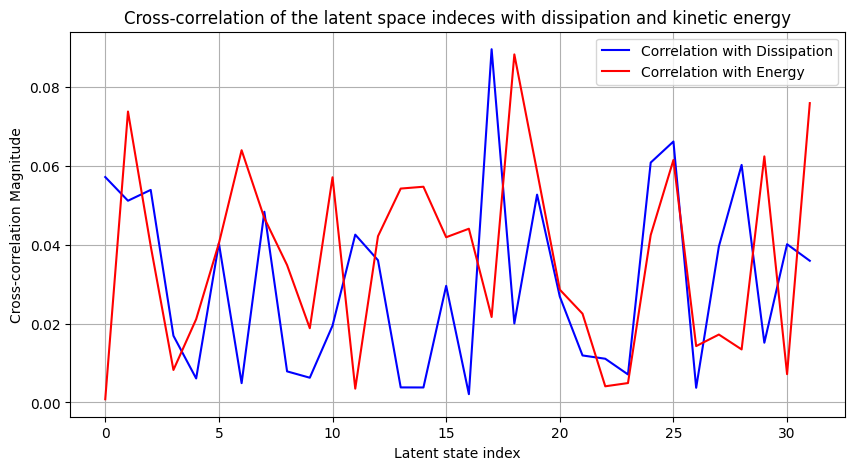

[17 25 24 28 18 31  1]


In [19]:
print(latent.shape)
print(corr_u_d.shape)
corr_with_dissip = np.zeros(latent.shape[1])
corr_with_energy = np.zeros(latent.shape[1])

for i in range(latent.shape[1]):
    corr_with_dissip[i] = np.corrcoef(latent[:, i], corr_u_d.reshape(corr_u_d.shape[0]))[0, 1]
    corr_with_energy[i] = np.corrcoef(latent[:, i], corr_u_k.reshape(corr_u_k.shape[0]))[0, 1]


plt.figure(figsize=(10, 5))
plt.plot(np.abs(corr_with_dissip), label='Correlation with Dissipation', color='blue')
plt.plot(np.abs(corr_with_energy), label='Correlation with Energy', color='red')
plt.xlabel('Latent state index')
plt.ylabel('Cross-correlation Magnitude')
plt.title('Cross-correlation of the latent space indeces with dissipation and kinetic energy')
plt.grid()
plt.legend()
plt.show()

indices_of_max_values_dissip = np.argsort(-np.absolute(corr_with_dissip).reshape(1, -1)[0])
indices_of_max_values_ke = np.argsort(-np.absolute(corr_with_energy).reshape(1, -1)[0])
first_x = np.append(indices_of_max_values_dissip[:4], indices_of_max_values_ke[:3])
print(first_x)

Looking at the graph above, we decided to use 4 max-correlated distinct latent space representations from the dissipation rate and 3 distinct latent space representations from the kinetic energy. This choice was made as our hardware could only handle up to 7 latent space states next to kinetic energy (K) and dissipation rate (D) axes. The other reason behind why dissipation rate contributed more to the latent state count is that the flow is constructed solving spectral methods, and we had a better precision of the dissipation energy calculation as opposed to the kinetic energy, therefore we wanted the clustering algorithm to be as accurate as it can be but also balanced between the two flow parameters.

In [20]:
concat_prev = None
for i in first_x:
    np_array = np.array([latent[:, i]]).reshape(latent.shape[0], 1)
    if concat_prev is None:
        concat_prev = np_array
    else:
        concat_prev = np.concatenate((concat_prev, np_array), axis=1)
latent_reshaped_first_x = (concat_prev.reshape(latent_reshaped.shape[0], len(first_x)))

### Cluster Identification

The algorithm is stored in another file, therefore we need to change the current path so that Python can retrieve the code from the file it is stored in. 

In [21]:
import sys
import os


sys.path.append(os.path.join(os.getcwd(), '..', 'MasterCode'))
notebook_path = os.getcwd()

The algorithm has the following hyperparameters:

- Re -> Reynolds number of the flow, set to 40.0 per client's request.
- N -> number of mode pairs (set to the number retrieved from the flow data)
- n -> number of modes
- T -> total number of time
- dt -> time step 

- Dissip -> Dissipation energy of the flow
- I -> Kinetic energy of the flow
- axes -> dimensions where the clustering is applied
- tol -> tolerance to determine what is considered as extreme. NOTE: This is left to the user-input since we want to place the user in the loop and ethically ensure that it is a technosocial system/
- M -> Hypercubes for the matrix calculations; lower increases speed but reduces accuracy
- min_clusters -> minimum amount of state-space clusters output
- max_it -> Total number of iterations done to assure numerical convergence

This algorithm is a numerical method to calculate maximum modularity, which is done through an eigenvalue decomposition problem much like principal component analysis. The algorithm takes about an hour to run since it is a greedy algorithm and an argmax calculation is needed. 

In [26]:
from my_func import *

The code sniplet below sets the flow parameters for the algorithm to register.

In [27]:
# Read pre-generated data
Re = re    # Reynolds number
N = 8  # 8 = n*2 modes (pair)
n = 4
T = T
dt = .01

In [28]:
partition = int(len(u_k_test_actual)) + 1
print(f'This is the amount of data points we are considering for the clustering algorithm: {partition}')

This is the amount of data points we are considering for the clustering algorithm: 2401


Below is the modularity maximization algorithm.

This is the tolerance we are considering: 3
Community:  0
Nodes: 453706661, 444706650, 444716650, 636813750, 636814761, 726823750, 535814761, 636814750, 535715761, 535715750, 827822850, 727822850, 535705760, 445715661, 545705661, 535705761, 535715661, 
Community:  1
Nodes: 827942920, 817932920, 818752832, 817932930, 827932930, 635914840, 535804740, 736923940, 736913840, 635814840, 635714840, 645915940, 644914840, 635914851, 645915850, 644915840, 726923941, 735924940, 635915841, 635915940, 544715650, 635914950, 635914850, 635915850, 544906851, 544806850, 544816850, 635914841, 826933941, 827933941, 444715651, 635804651, 445715651, 535715751, 454716651, 353716651, 735914951, 453706552, 454706652, 444714563, 
Community:  2
Nodes: 545815621, 645814720, 635824820, 635814820, 826922830, 827922740, 817921840, 817822840, 726922840, 736922840, 735913841, 645914840, 735913840, 735923951, 736912750, 727822750, 444706511, 735913831, 735913842, 736912751, 826912761, 736912761, 
Community:  3
Nodes: 

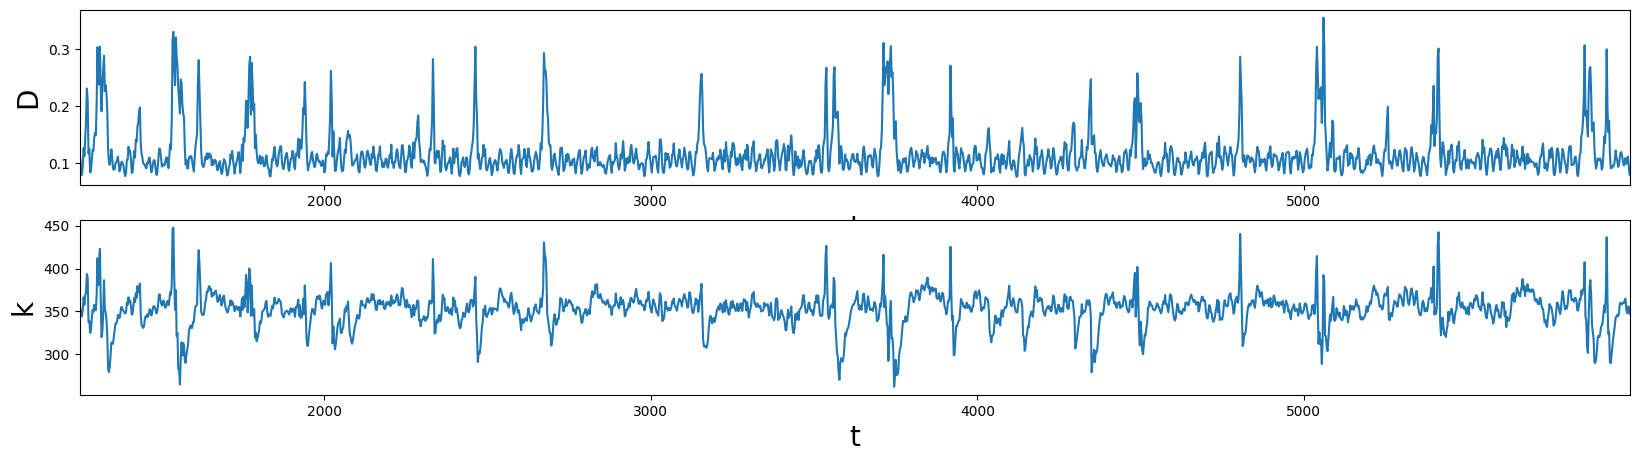

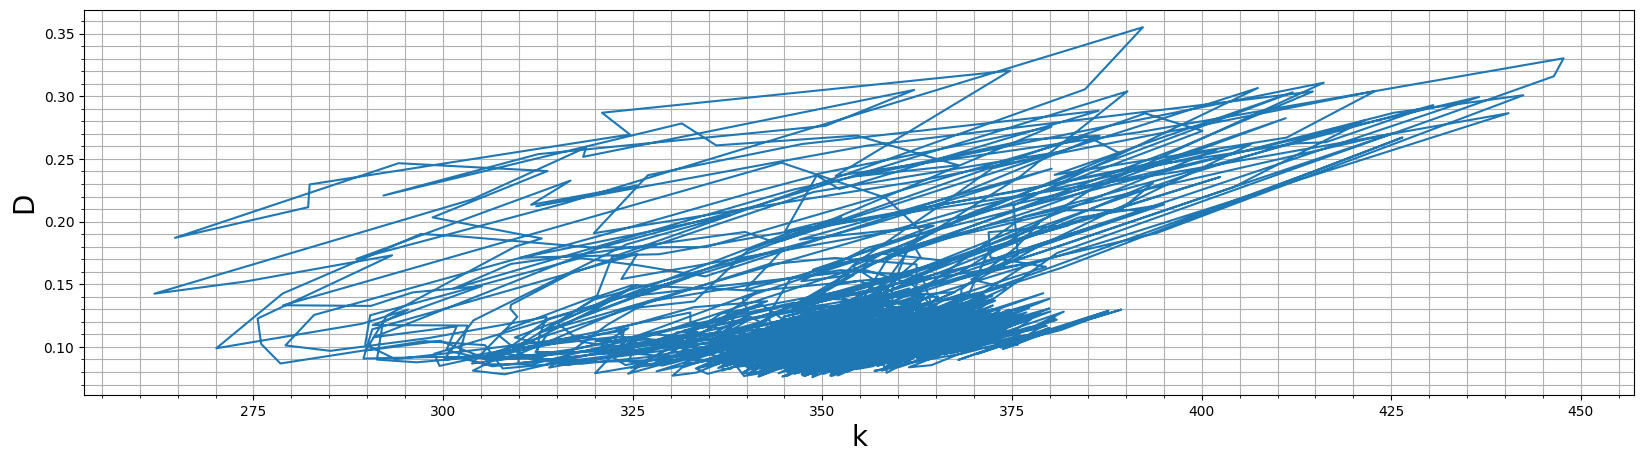

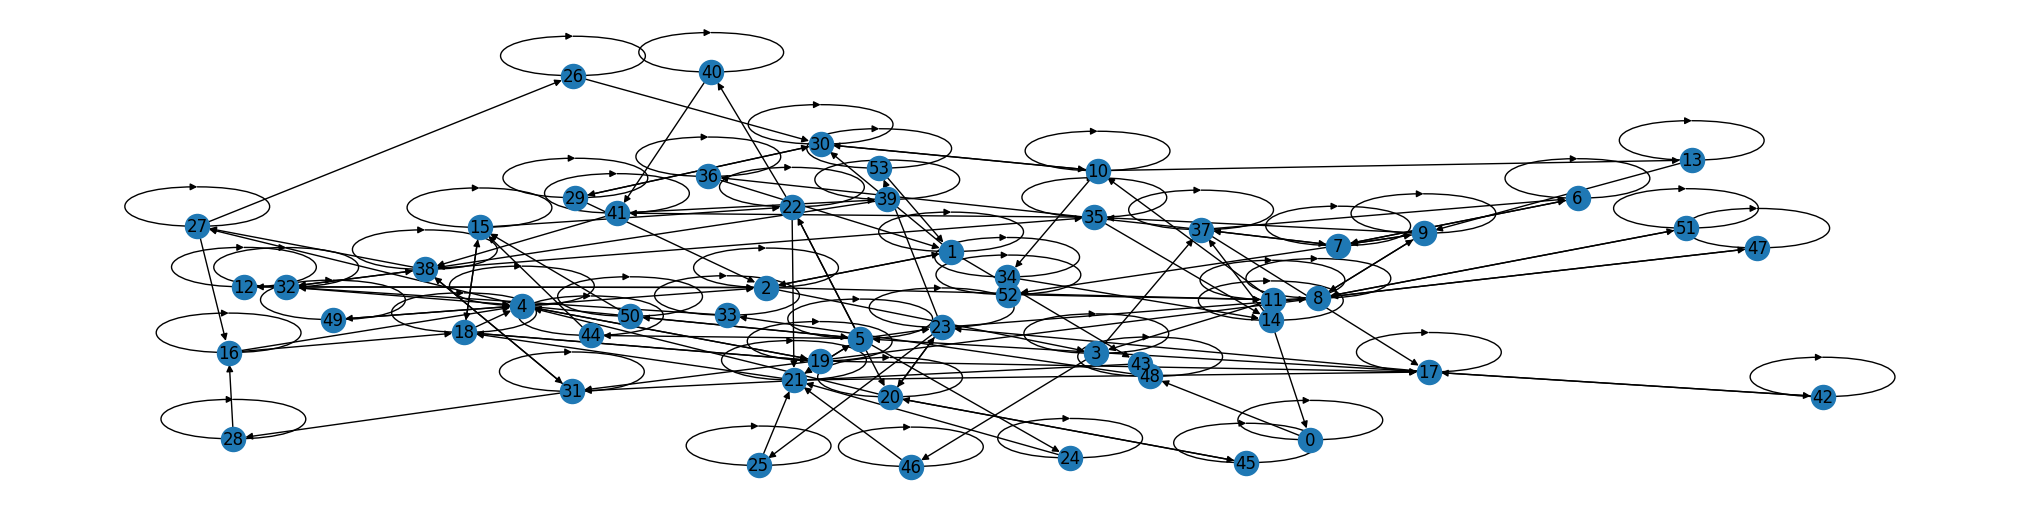

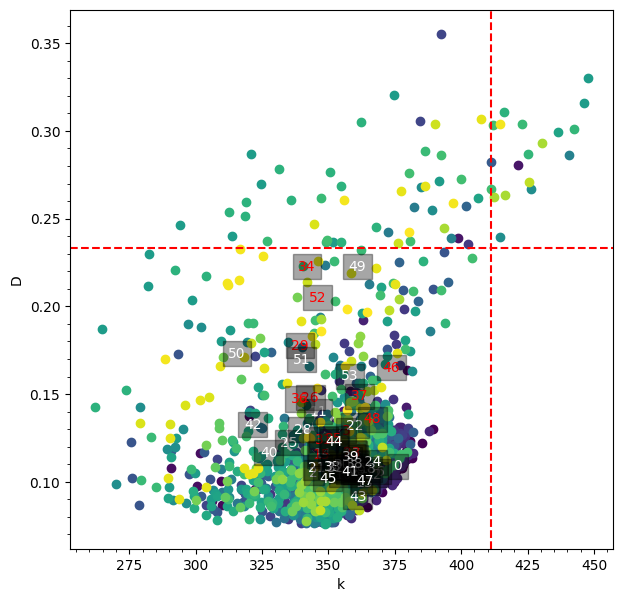

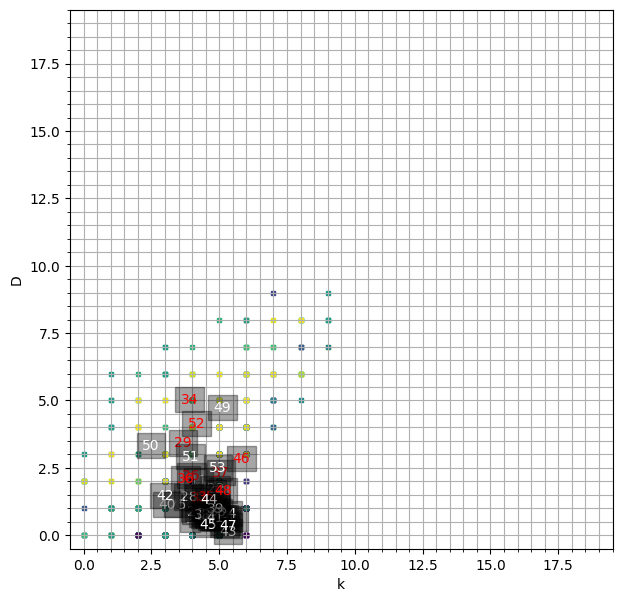

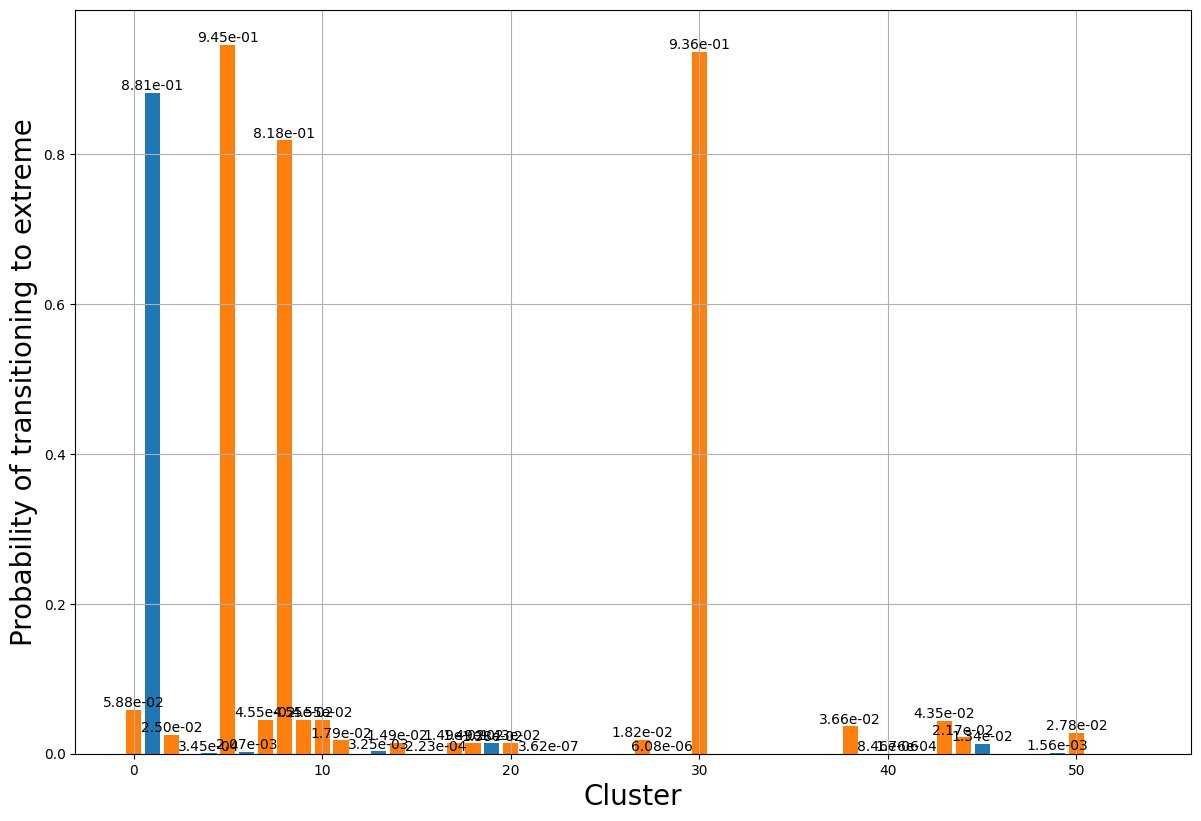

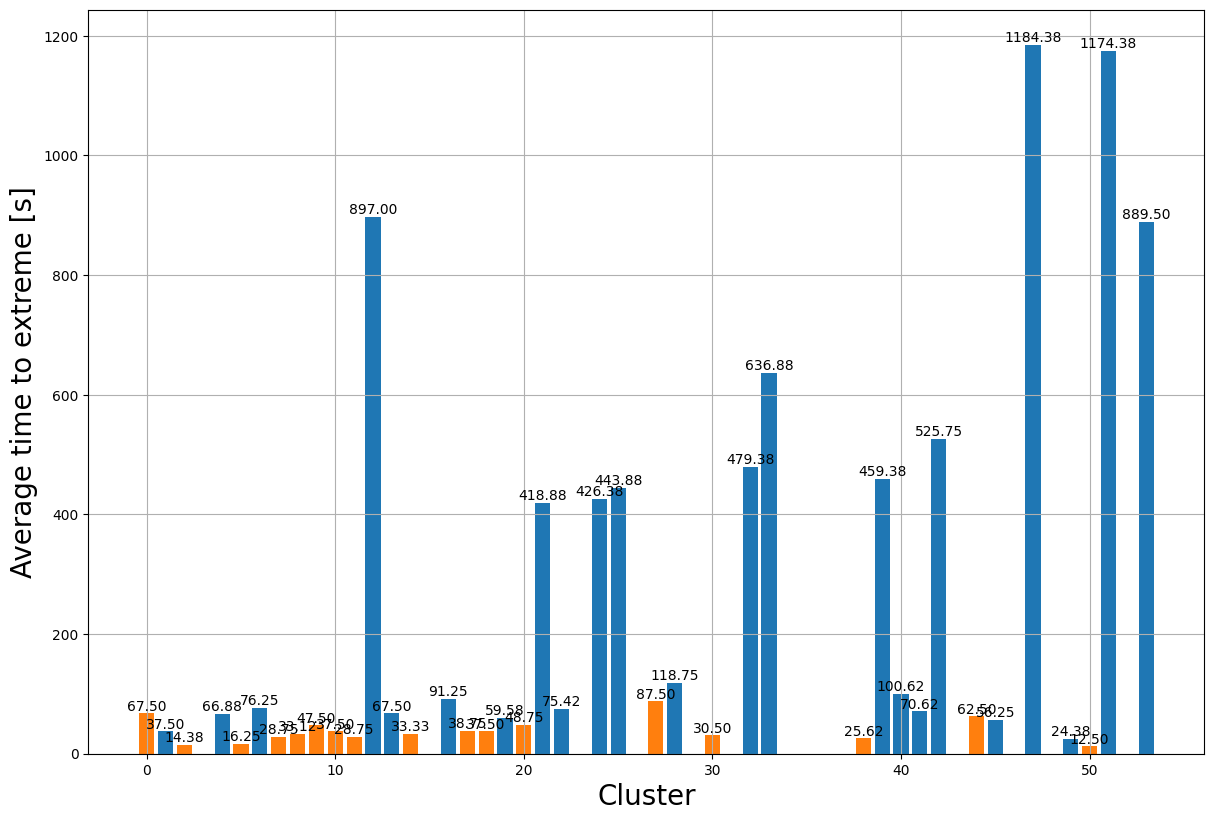

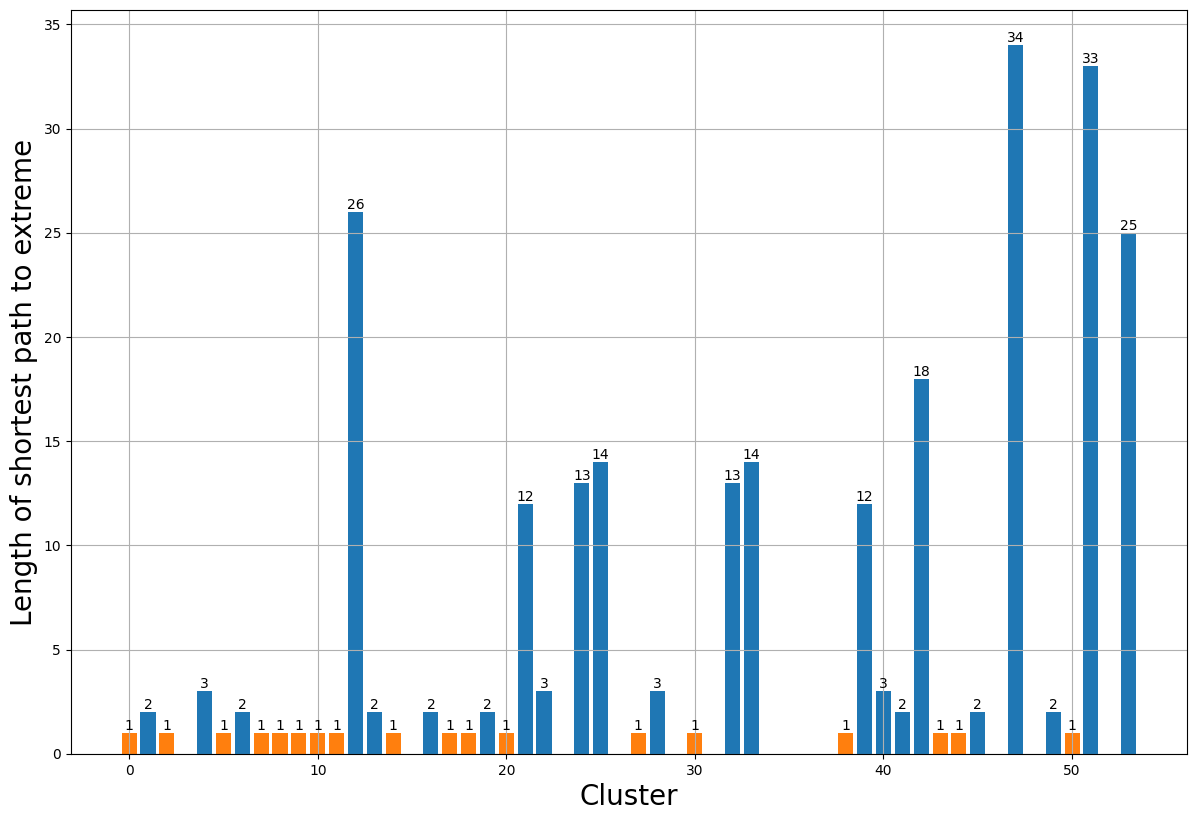

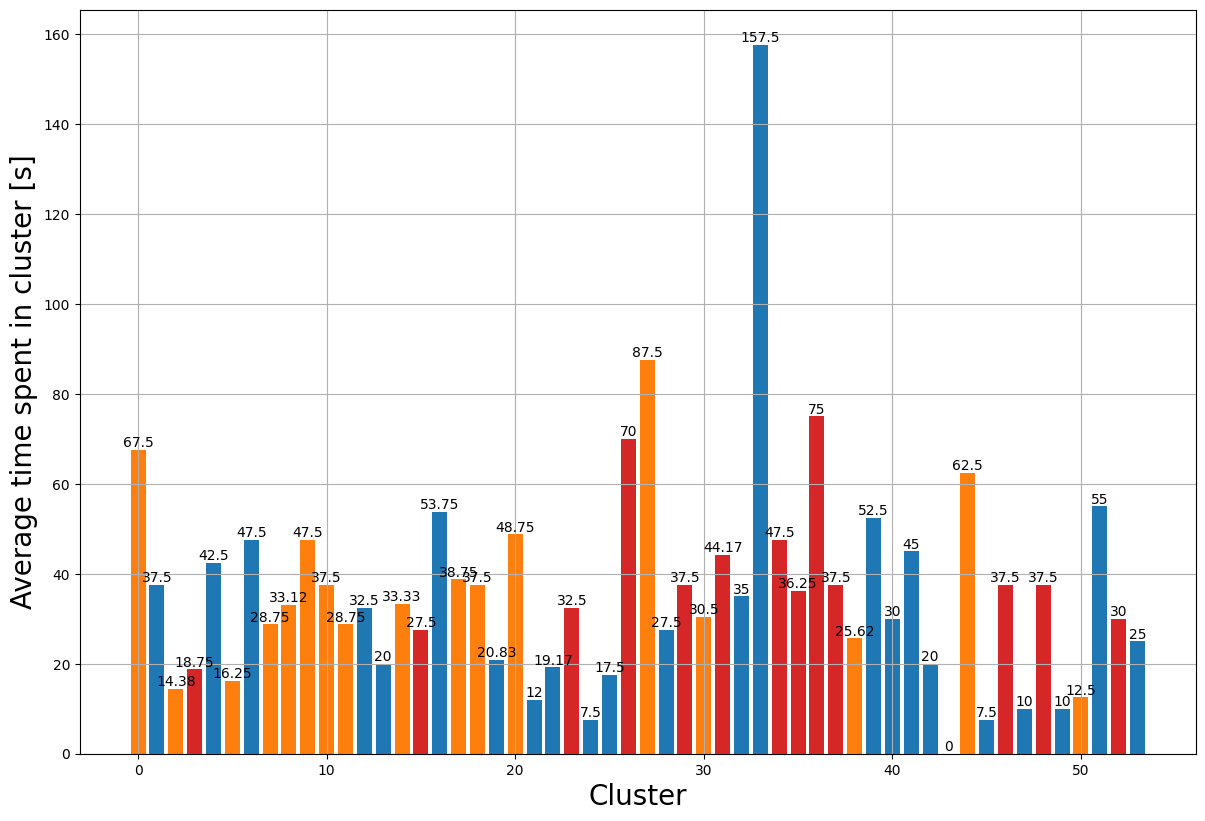

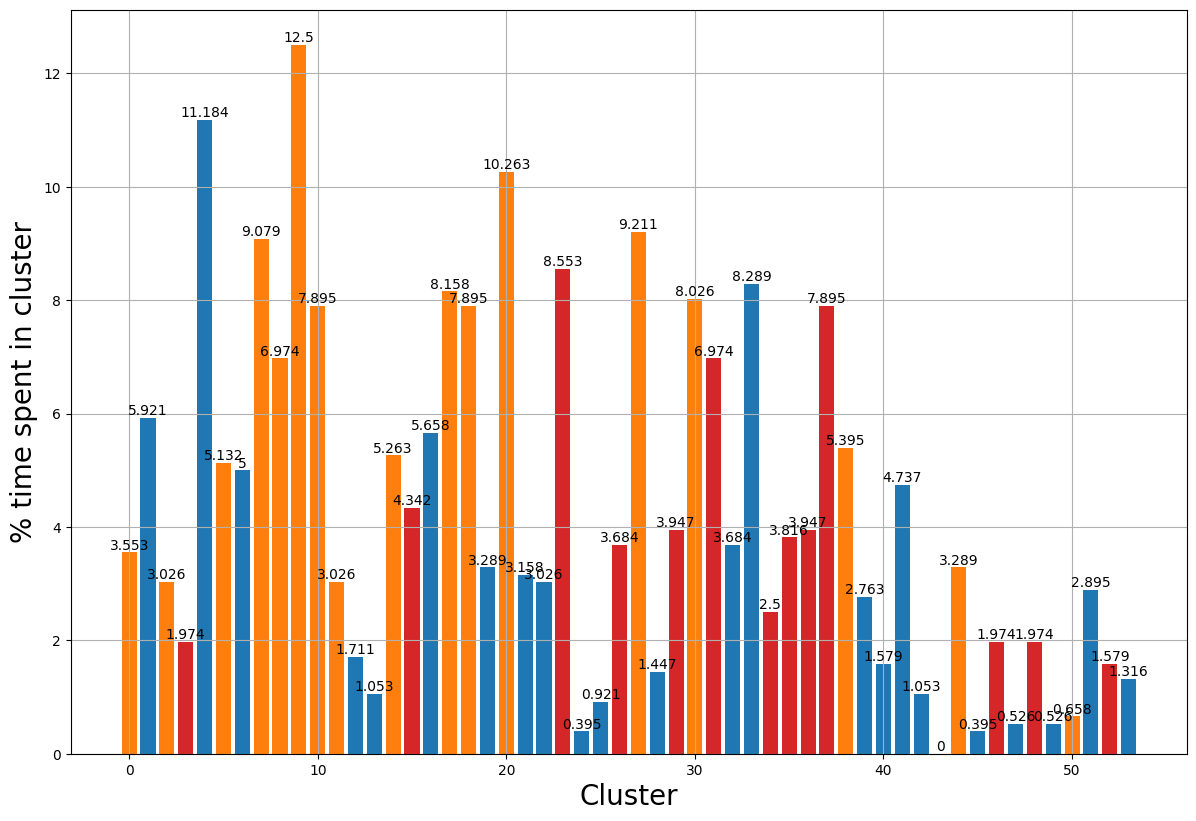

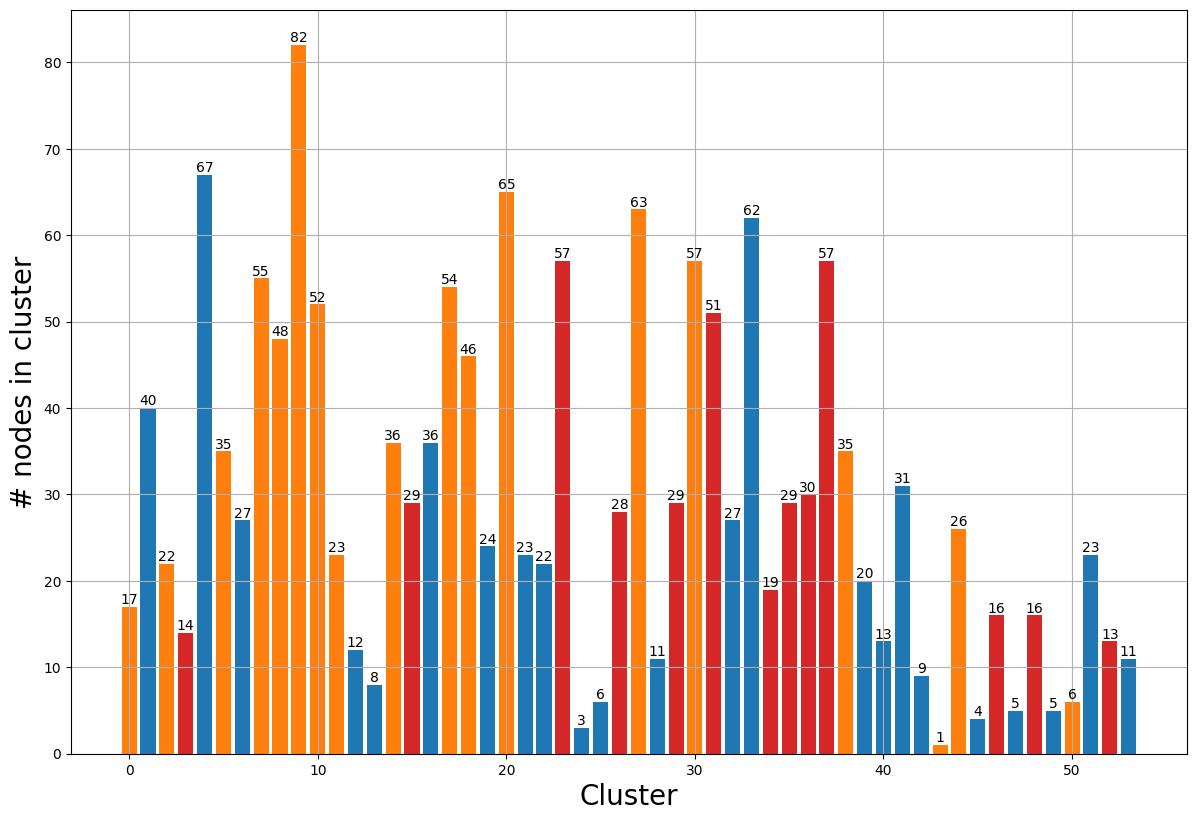

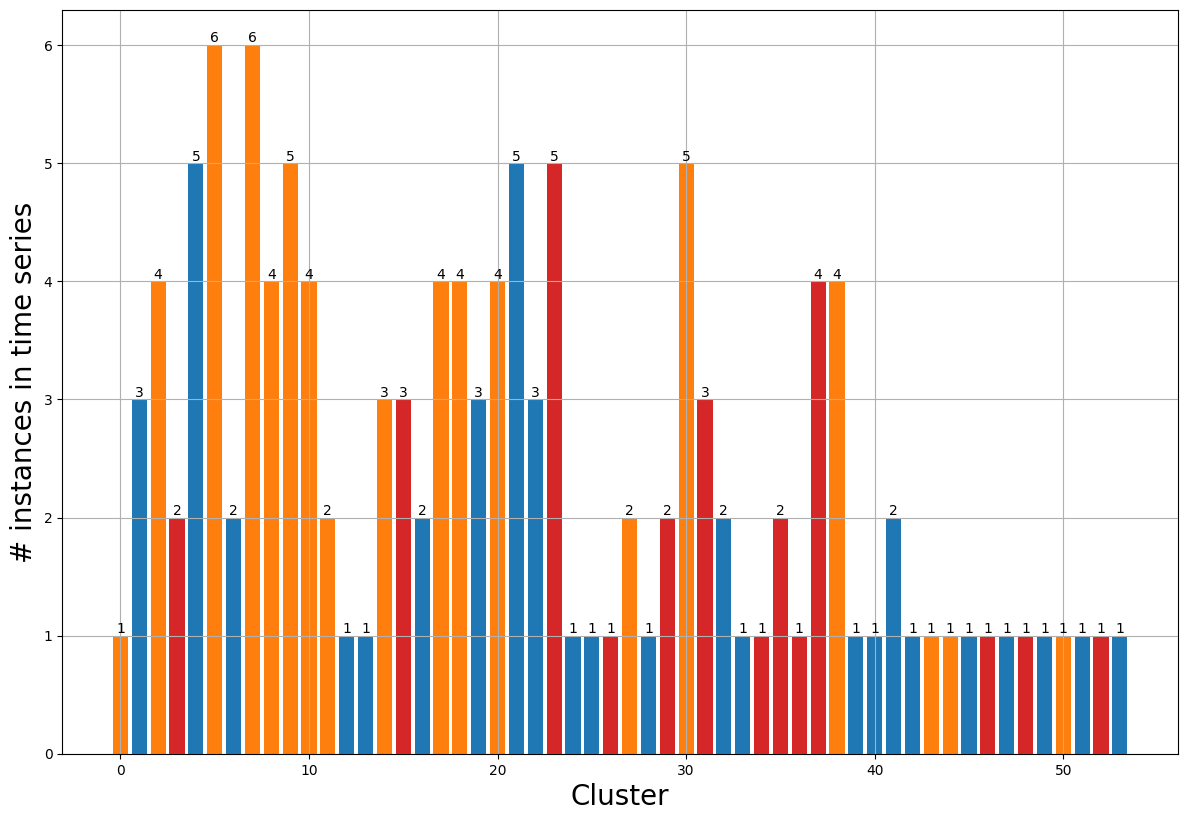

In [30]:
t = np.load('t.npy')
Diss = dissip.reshape((len(u_d_test_actual),1)) #/ (re * (2 * np.pi) ** 2)
#u_d_test_actual.reshape((len(u_d_test_actual),1))
I = u_k_test_actual.reshape((len(u_k_test_actual),1)) * (2 * np.pi) ** 2
x = np.append(Diss, I, axis=1)    # create matrix for specific parameters of the data series

x = np.append(x, latent_reshaped_first_x, axis=1) 

# Normalizing the input for convergence
# x_mean = np.mean(x[:, :2], axis=0)
# x_std = np.std(x[:, :2], ddof=1, axis=0)
# x[:, :2] = (x[:, :2] - x_mean)/x_std


t = t[500:partition]
x = x[500:partition]
extr_dim =[0, 1] # Define the first two parameters (k and D) as the coordinates used to define extreme events
tol = 3#This means that the threshold is + tol*std higher than the mean
print(f'This is the tolerance we are considering: {tol}')
nr_dev = tol #1.4 #float for the threshold value

# Number of tessellation sections per phase space dimension
M = 10 #use smaller numbers to control the size of the matrix #10

plotting = True
min_clusters = len(x)/2
max_it = 1

# Tessellating and clustering loop
clusters, D, P = extreme_event_identification_process(t,x,M,extr_dim,"kolmogorov_kD", min_clusters, max_it, 'backwards', nr_dev,plotting, False) #changed classic to backwards

# Calculate the statistics of the identified clusters
min_prob, min_time = calculate_statistics(extr_dim, clusters, P, len(t))
plt.show()

# Check on "new" data series
x_tess,temp = tesselate(x,M,extr_dim,nr_dev)     # Tessellate data set (without extreme event identification)
x_tess = tess_to_lexi(x_tess, M, x.shape[1])
x_clusters = data_to_clusters(x_tess, D, x, clusters) # Translate data set to already identified clusters
 

is_extreme = np.zeros_like(x_clusters)
for cluster in clusters:
    is_extreme[np.where(x_clusters==cluster.nr)]=cluster.is_extreme # New data series, determining whether the current
                        # state of the system is extreme (2), precursor (1) or normal state (0)

# Calculate the false positive and false negative rates
avg_time, instances, instances_extreme_no_precursor, instances_precursor_no_extreme, instances_precursor_after_extreme = backwards_avg_time_to_extreme(is_extreme,dt)

The algorithm is designed to output 0% false negatives due to the way how an extreme event is classified within the algorithm. However, the algorithm has to make corrections for the false positives (i.e. there is a precursor event after an extreme event) it has found during the clustering since aerodynamically this result is redundant for flow understanding. Below, we plot the performance of the algorithm.

In [31]:
print('Average time from precursor to extreme:', avg_time, ' s')
print('Nr times when extreme event had a precursor:', instances)
print('Nr extreme events without precursors (false negative):', instances_extreme_no_precursor)
print('Percentage of false negatives:', instances_extreme_no_precursor/(instances+instances_extreme_no_precursor)*100, ' %')
print('Nr precursors without a following extreme event (false positives):', instances_precursor_no_extreme)
print('Percentage of false positives:', instances_precursor_no_extreme/(instances+instances_precursor_no_extreme)*100, ' %')
print('Nr precursors following an extreme event:', instances_precursor_after_extreme)
print('Corrected percentage of false positives:', (instances_precursor_no_extreme-instances_precursor_after_extreme)/(instances+instances_precursor_no_extreme)*100, ' %')

Average time from precursor to extreme: 0.2395833333333333  s
Nr times when extreme event had a precursor: 24
Nr extreme events without precursors (false negative): 0
Percentage of false negatives: 0.0  %
Nr precursors without a following extreme event (false positives): 17
Percentage of false positives: 41.46341463414634  %
Nr precursors following an extreme event: 14
Corrected percentage of false positives: 7.317073170731707  %


The algorithm retrieves which events are normal, precursor and extreme and stores them in the parameter <code>is_extreme</code>. This list includes 0 for normal, 1 for precursor and 2 for extreme per time stamp and it has the same length as the flowfield. 

In [32]:
list_for_checking_extremes = (is_extreme)

The code below is used to get the index of the timestamps that are classified as extreme and precursor for visualization purposes.

In [33]:
extreme_clusters = np.where(is_extreme == 2)
precursor_clusters = np.where(is_extreme == 1)

The code below plots the kinetic energy graph over the total time of the flow and classifies the points according to their extremity. Blue indicates that it is classified as normal event, yellow indicates that it is a precursor and red indicates that it is an extreme event. 

In [34]:
u_k_test_actual_rehsaped = u_k_test_actual.reshape(u_k_test_actual.shape[0])
u_d_test_actual_rehsaped = u_d_test_actual.reshape(u_k_test_actual.shape[0])

precurse = list(precursor_clusters[0])
extreme = list(extreme_clusters[0])

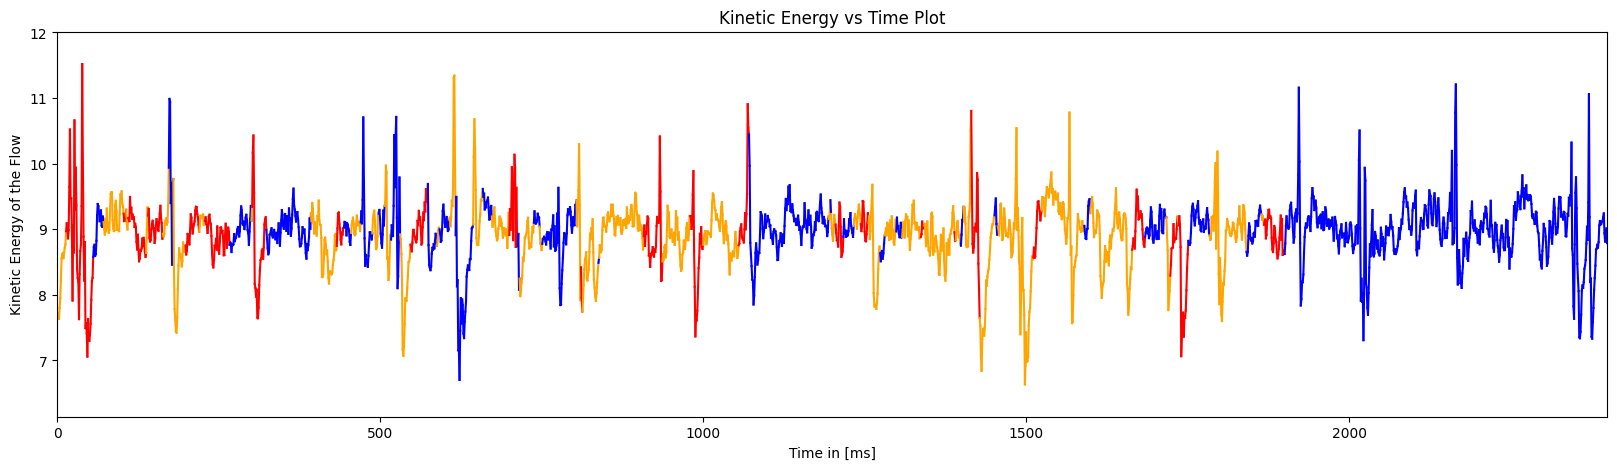

In [38]:
normal = []
time_allocated = np.arange(len(u_k_test_actual_rehsaped))
for i in range(len(u_k_test_actual_rehsaped[:partition])):
    if i in precurse:
        #plt.plot(u_d_test_actual_rehsaped[i], u_k_test_actual_rehsaped[i], 'o', color='orange')
        #plt.plot(u_d_test_actual_rehsaped[i:i+2], u_k_test_actual_rehsaped[i:i+2], '-o', color='orange')
        plt.plot(time_allocated[i:i+2], u_k_test_actual_rehsaped[i:i+2], '-', color='orange') #plots the time series
    elif i in extreme:
        #plt.plot(u_d_test_actual_rehsaped[i], u_k_test_actual_rehsaped[i],'o', color='red')
        #plt.plot(u_d_test_actual_rehsaped[i:i+2], u_k_test_actual_rehsaped[i:i+2],'-o', color='red')
        plt.plot(time_allocated[i:i+2], u_k_test_actual_rehsaped[i:i+2], '-', color='red') #plots the time series
    else:
        normal.append(i)
        #plt.plot(u_d_test_actual_rehsaped[i], u_k_test_actual_rehsaped[i],'o', color='blue')
        plt.plot(time_allocated[i:i+2], u_k_test_actual_rehsaped[i:i+2], '-', color='blue') #plots the time series

std_of_kinetic = np.std(u_k_test_actual_rehsaped[:partition], axis=0, ddof=1)

plt.margins(0)
plt.ylim((min(u_k_test_actual_rehsaped[:partition]) - std_of_kinetic, max(u_k_test_actual_rehsaped[:partition]) + std_of_kinetic))
plt.xlabel('Time in [ms]')
plt.ylabel('Kinetic Energy of the Flow')
plt.title('Kinetic Energy vs Time Plot')
plt.show()

The same method is done for the dissipation rate of the flow. First, we are plotting the dissipation rate of the plot where the signal is colored. Blue patches indicate normal states, yellow the precursors and red indicate the extreme states.

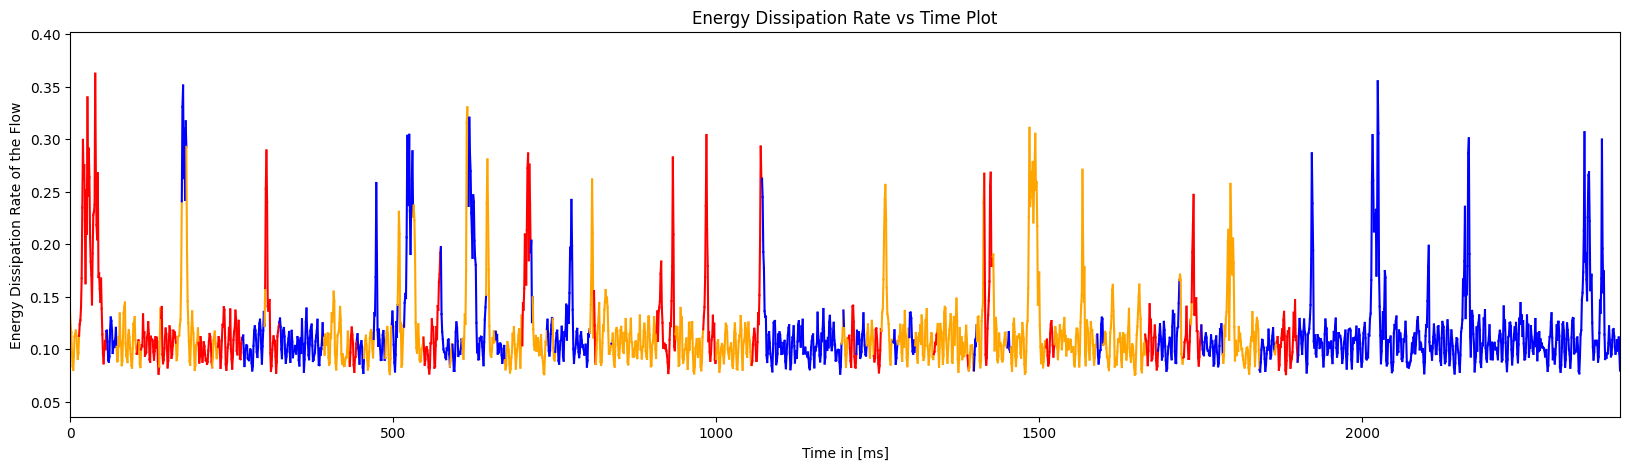

In [37]:
plt.rcParams['figure.figsize'] = [20, 5]  # Adjust the numbers as needed
std_of_dissipation = np.std(Diss[:partition], axis=0, ddof=1)
for i in range(len(Diss[:partition])):
    if i in precurse:
        #plt.plot(u_d_test_actual_rehsaped[i], u_k_test_actual_rehsaped[i], 'o', color='orange')
        #plt.plot(u_d_test_actual_rehsaped[i:i+2], u_k_test_actual_rehsaped[i:i+2], '-o', color='orange')
        plt.plot(np.arange(len(Diss))[i:i+2], Diss[i:i+2], '-', color='orange')
    elif i in extreme:
        #plt.plot(u_d_test_actual_rehsaped[i], u_k_test_actual_rehsaped[i],'o', color='red')
        #plt.plot(u_d_test_actual_rehsaped[i:i+2], u_k_test_actual_rehsaped[i:i+2],'-o', color='red')
        plt.plot(np.arange(len(Diss))[i:i+2], Diss[i:i+2], '-', color='red')
    else:
        normal.append(i)
        #plt.plot(u_d_test_actual_rehsaped[i], u_k_test_actual_rehsaped[i],'o', color='blue')
        plt.plot(np.arange(len(Diss))[i:i+2], Diss[i:i+2], '-', color='blue')

plt.margins(0)
plt.ylim((min(Diss[:partition]) - std_of_dissipation, max(Diss[:partition]) + std_of_dissipation))
plt.xlabel('Time in [ms]')
plt.ylabel('Energy Dissipation Rate of the Flow')
plt.title('Energy Dissipation Rate vs Time Plot')
plt.show()

# Decoding the Extremes

The code sniplet below gets the timestamps for each cluster with the extremity.

In [182]:
dic_of_extremeties = {}
for cluster_id in [clus.nr for clus in clusters]:
    indices = np.where(x_clusters == cluster_id)[0]
    if cluster_id not in dic_of_extremeties:
        cluster_object = [clus for clus in clusters if clus.nr == cluster_id][0]
        for i in range(len(is_extreme)):
            if i in indices:
                extremety = is_extreme[i]
        dic_of_extremeties[cluster_id] = (extremety, indices, cluster_object)
    #print(f"Indices for cluster {cluster_id}: {indices}")

In [183]:
latent_reshaped_extremes = np.array([latent_reshaped[idx] for (idx, val) in enumerate(extreme)])
latent_reshaped_normal = np.array([latent_reshaped[idx] for (idx, val) in enumerate(normal)])

In [184]:
decoded_extremes = model_decoder.forward(latent_reshaped_extremes.reshape(latent_reshaped_extremes.shape[0], 1, 1, latent_reshaped_extremes.shape[1]))
decoded_normal = model_decoder.forward(latent_reshaped_normal.reshape(latent_reshaped_normal.shape[0], 1, 1, latent_reshaped_normal.shape[1]))
print(decoded_extremes.shape)
print(decoded_normal.shape)

(726, 48, 48, 2)
(787, 48, 48, 2)


## Precursor Decoded

The code below gets the precursor clusters that have the highest probability of transitioning to an extreme state. This threshold was chosen to be 1 sigma higher than the mean as most of the clusters have nearly 0 probability meaning the mean is very close to 0 - therefore a margin of error (being 1 sigma) was added to get the cluster indices corresponding to high probability values.

In [185]:
thresold_min_prob = np.mean(min_prob) + np.std(min_prob, ddof=1)
indices_min_prob = np.where(min_prob >= thresold_min_prob)[0]
states = [dic_of_extremeties[i] for i in indices_min_prob]
print(len(states))

6


The code below decodes all of the states that have the highest probability of transitioning to an extreme state. It then plots the velocity and the energy of the 'average' percursor state which is the average of the velocities for these states. The reason why the average is plotted is to smoothen out the noise and see how an 'average' precursor is represented.

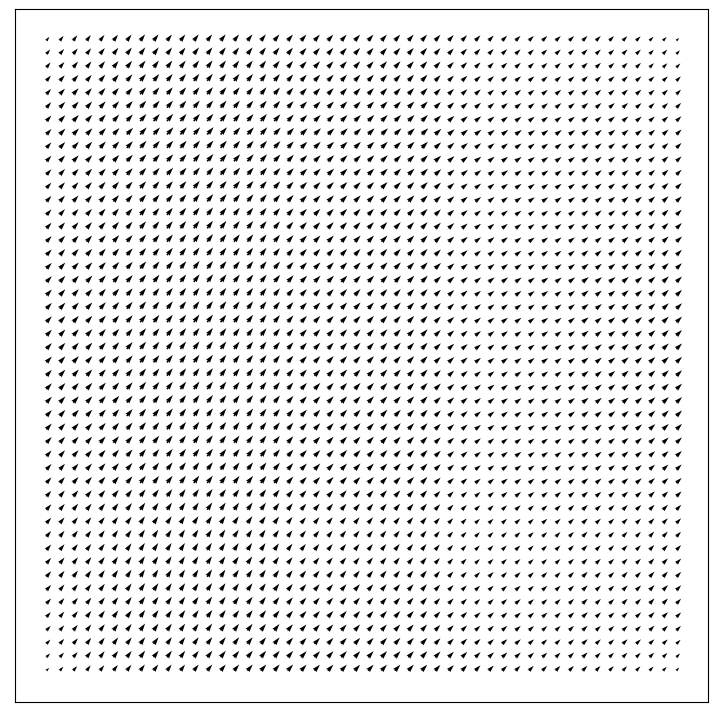

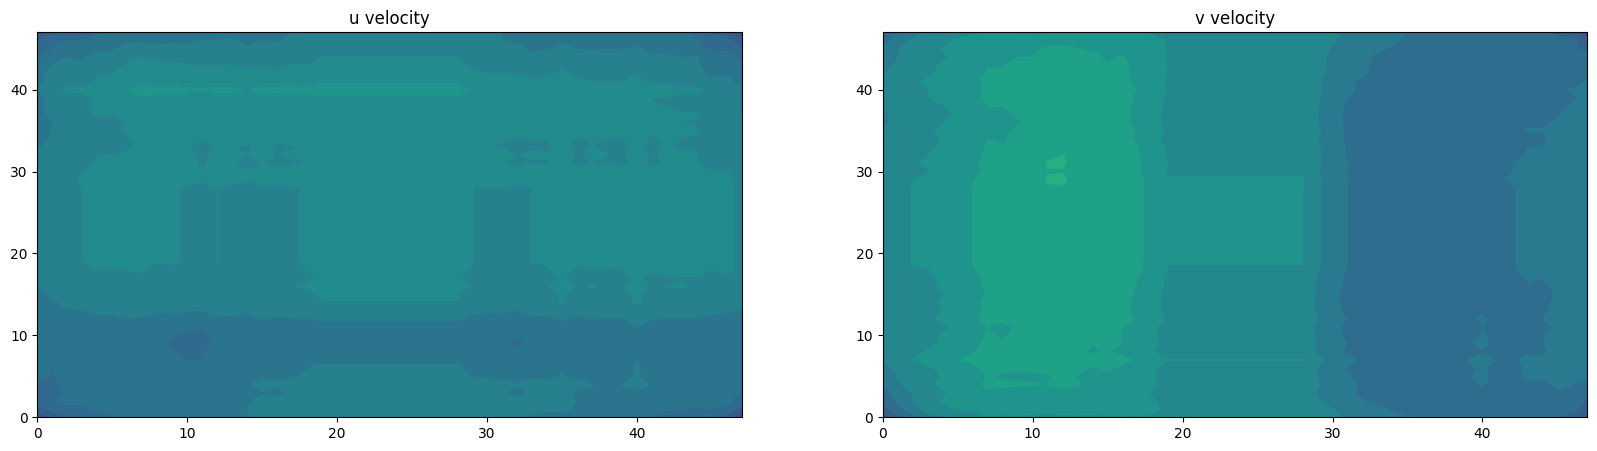

c:\Users\alial\OneDrive\Desktop\AE\year3\Minor\CapstoneProject\TI3165TU-Capstone-Applied-AI-LOCAL\main\..\FlowCompression\ParentClass.py:441: UserWarning: The following kwargs were not used by contour: 'min', 'max'
  plt.contourf(Model.energy(nxnx2), min=0, max=1.1)


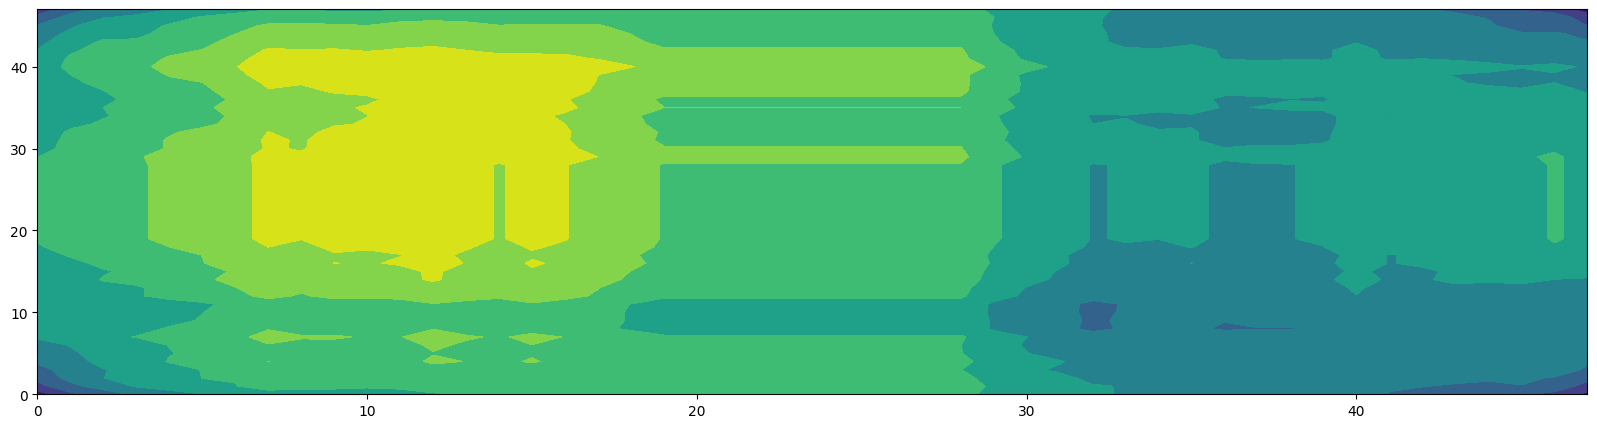

In [186]:
prev = None
for i in range(len(states)):
    if states[i][0] == 1:
        times = states[i][1]
        for t in times:
            decoded_cluster_precursor = model_decoder.forward(latent_reshaped[t].reshape(1, 1, 1, latent_reshaped.shape[1]))
            if prev is None:
                prev = np.array(decoded_cluster_precursor)
            else:
                prev = np.append(prev, decoded_cluster_precursor, axis=0)

average = np.mean(prev, axis=0)

AE.plot_velocity(average)
AE.u_v_plot(average)
AE.plot_energy(average)

## Extreme Decoded

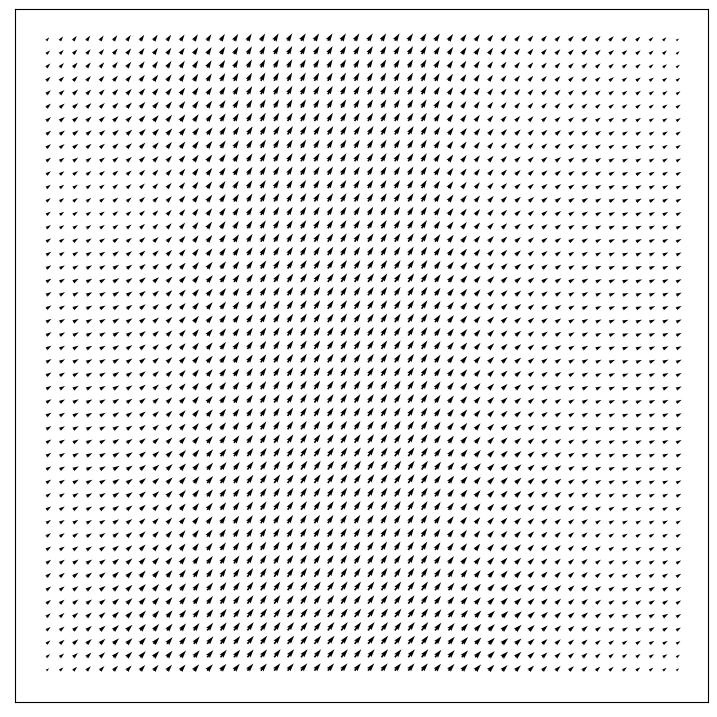

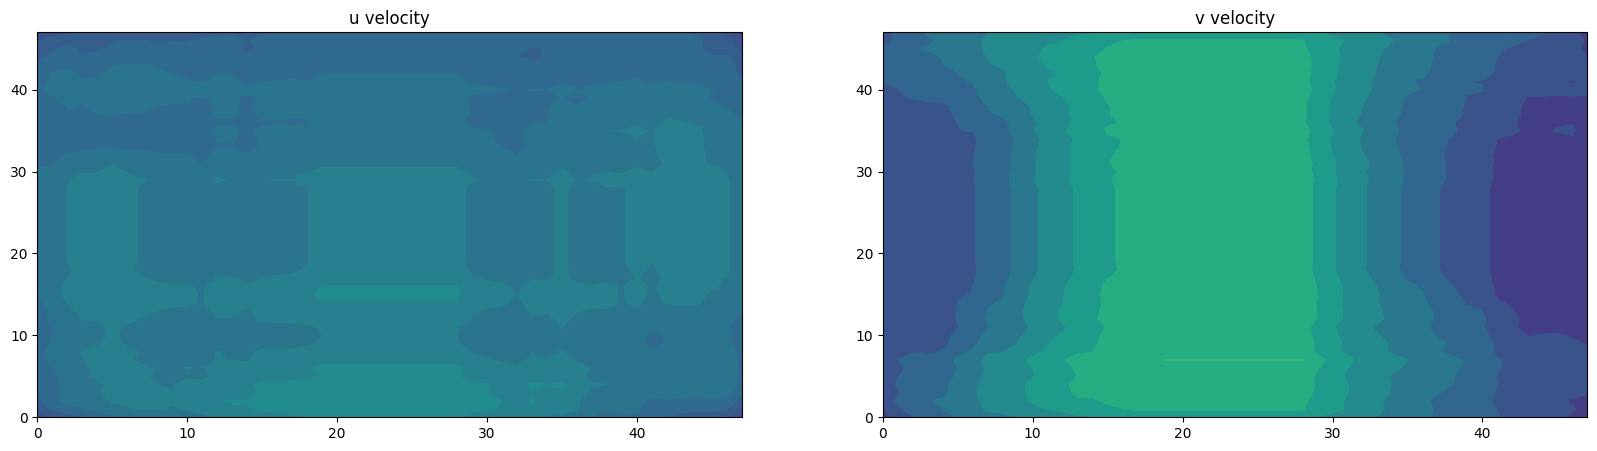

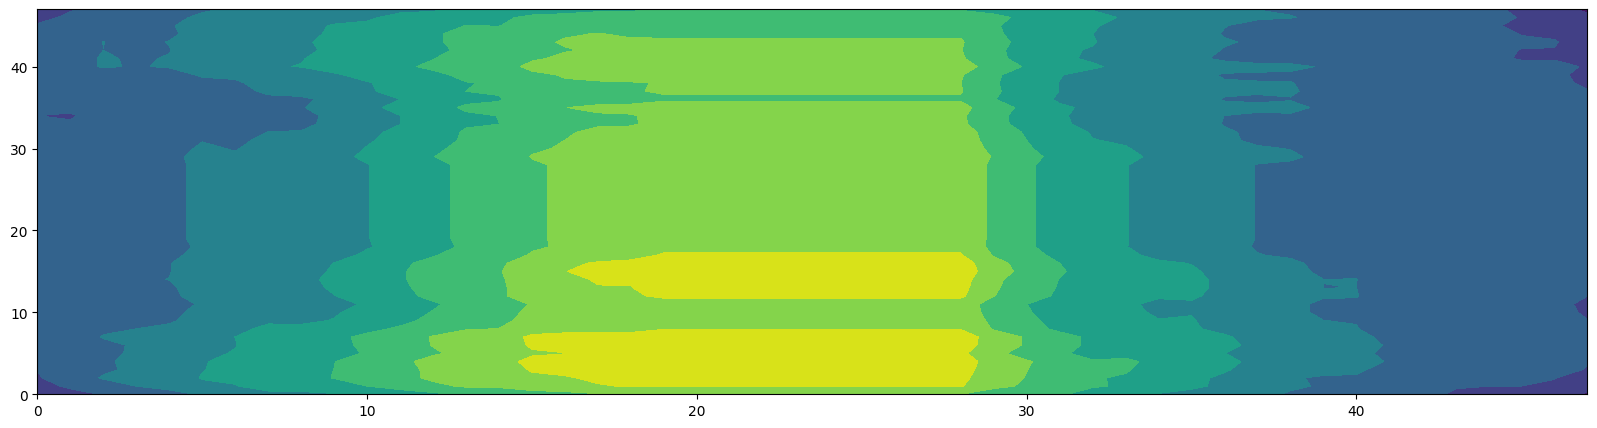

In [187]:
AE.plot_velocity(decoded_extremes[5])
AE.u_v_plot(decoded_extremes[5])
AE.plot_energy(decoded_extremes[5])

## Normal Decoded

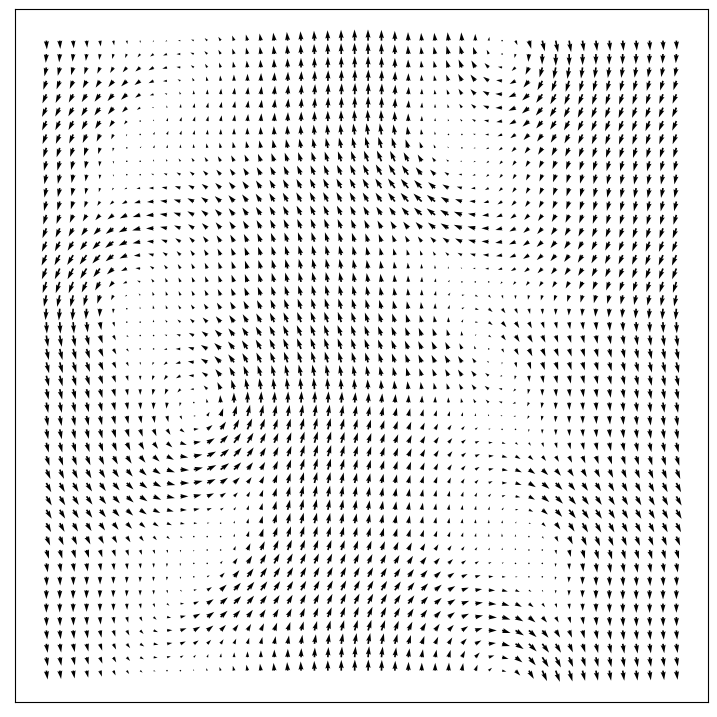

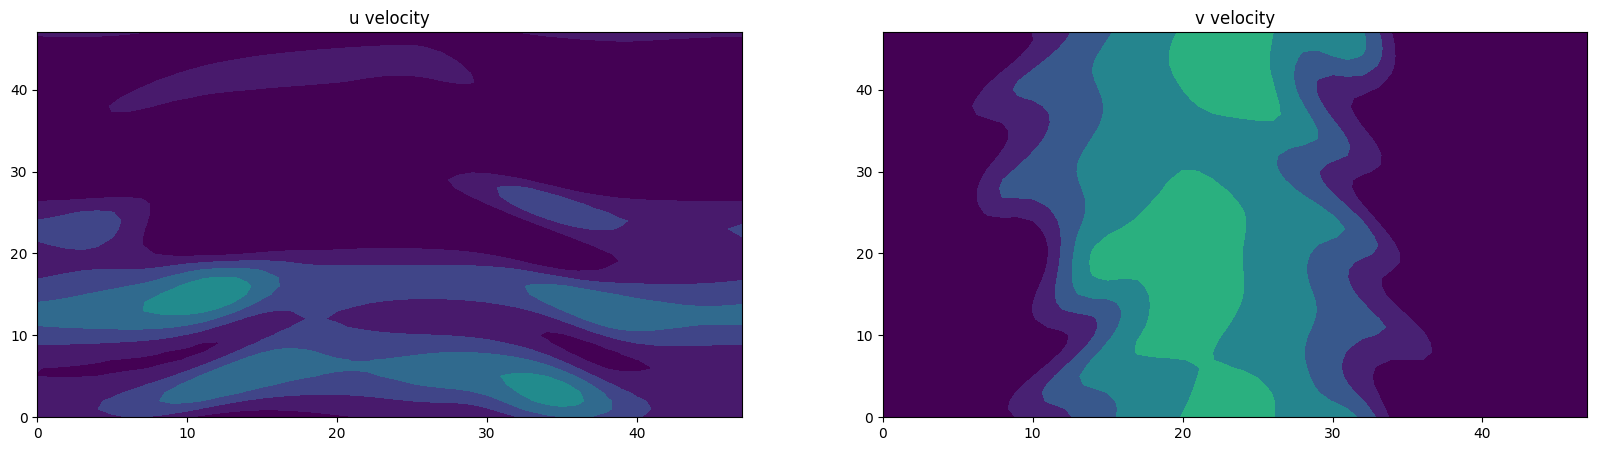

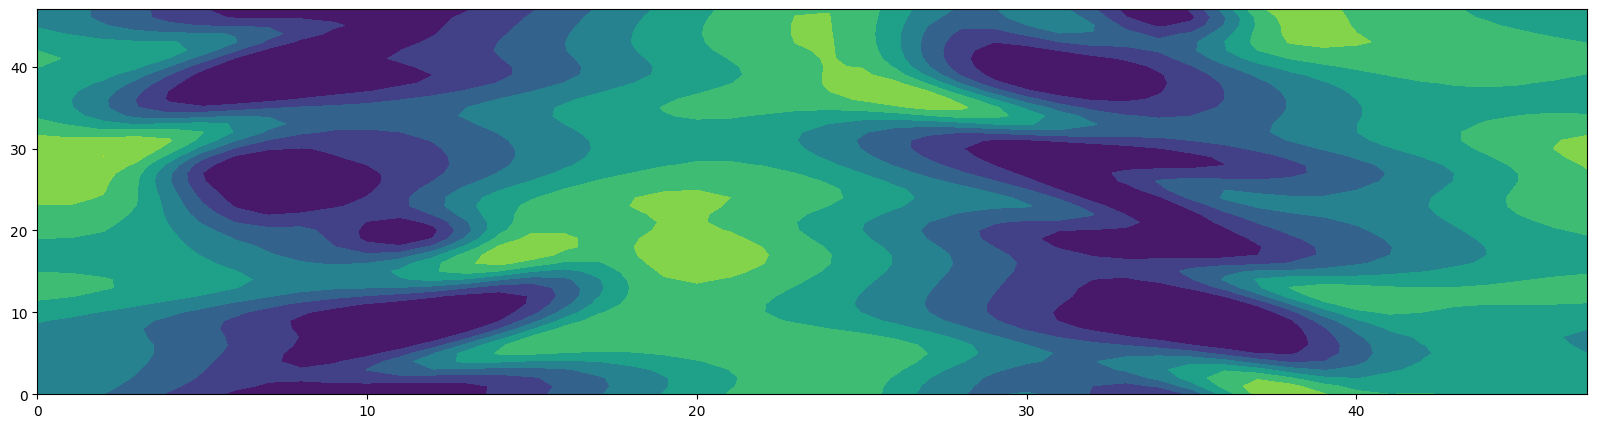

In [189]:
AE.plot_velocity(u[5])
AE.u_v_plot(u[5])
AE.plot_energy(u[5])